# Math 104B Homework 5
**Name.** <span style="color:red">Kelly Wang</span> <br>
**Id.** <span style="color:red">5351010</span>

## Exercise 1
#### 1a
Given that $-\Delta u = f(x,y), 0\leq x, y \leq 1$ and $\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$, we can construct $f(x,y)$ by substituting $u$ into our PDE. <br/><br/>

$u(x,y) = \sin(16\pi x(1-x)y(1-y))$<br/><br/>

$\frac{\partial u}{\partial x} = \cos(16\pi x(1-x)y(1-y)) \cdot [16\pi(y-1)y(2x-1)]$ <br/><br/>

$\frac{\partial u}{\partial y} = \cos(16\pi x(1-x)y(1-y)) \cdot [16pi(x-1)x(2y-1)]$ <br/><br/>

$\frac{\partial^2 u}{\partial x^2} = -32\pi(y-1)y[8\pi(y-1)y(2x-1)^2\sin(16\pi(y-1)y(x-1)x)-\cos(16\pi(y-1)y(x-1)x)]$ <br/><br/>
$\frac{\partial^2 u}{\partial y^2} = -32\pi(x-1)x[8\pi(x-1)x(2y-1)^2\sin(16\pi(x-1)x(y-1)y) - \cos(16\pi(x-1)x(y-1)y)]$ <br/><br/>

$f(x,y) = 32\pi(y-1)y[8\pi(y-1)y(2x-1)^2\sin(16\pi(y-1)y(x-1)x)-\cos(16\pi(y-1)y(x-1)x)] +32\pi(x-1)x[8\pi(x-1)x(2y-1)^2\sin(16\pi(x-1)x(y-1)y) - \cos(16\pi(x-1)x(y-1)y)])$

#### 1b
I'm not sure why I'm not getting order two accuracy. I calculated a couple rows for A and saw that $\frac{4}{h^2}$ was on the diagonals and found the (maximum) 5 placements of $-\frac{1}{h^2}$ per row. However, not getting the correct accuracy can also help us to see and conceptualize what it's doing. If we look at our approximation, we can first see that the alpha value is converging to 1 instead of 2. Then at each n value, our plot is slightly off from the actual solution plot but it is convering towards it, just at a slower rate. If we had the correct degree of accuracy, it would converge faster and (obviously) match up with the actual solution plot. 

10


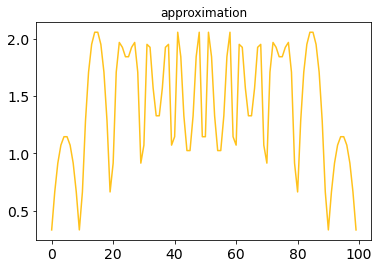

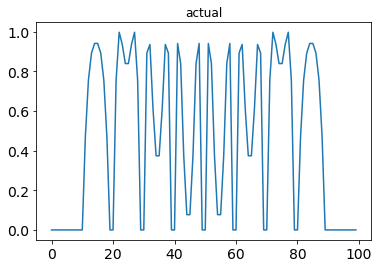

20


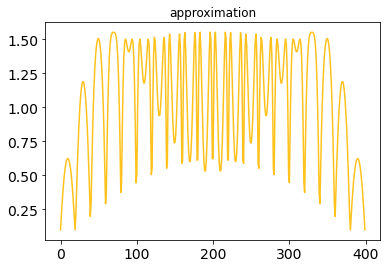

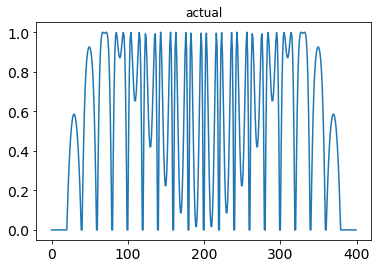

40


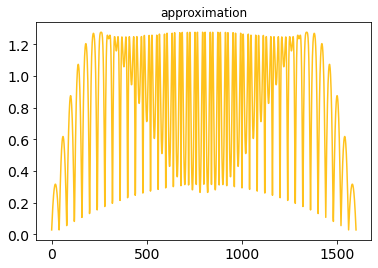

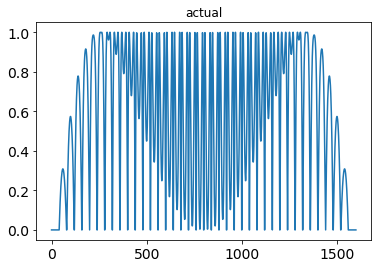

80


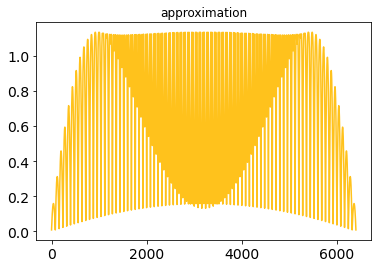

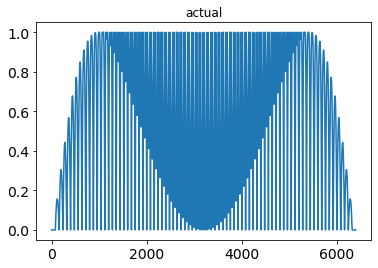

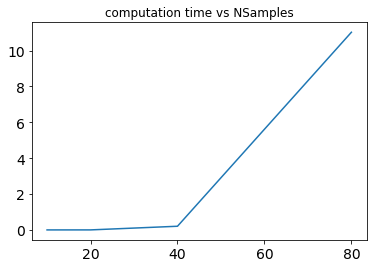

                  h |             Error |             alpha
--------------------+-------------------+-------------------
 0.111111111111111  | 1.14478530441046  | 0
 0.0526315789473684 | 0.623394299421694 | 0.813412009854506
 0.0256410256410256 | 0.3158629774774   | 0.945416895085554
 0.0126582278481013 | 0.1578775235888   | 0.982437300055607


In [196]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import numpy as np
import time

from tabulate import tabulate
from mpltools import annotation
from math import *


# NSamples  = [10, 20, 40, 80, 160, 320]
NSamples = [10, 20, 40, 80]

def f(x,y):
    return 32*np.pi*(y-1)*y*(8*np.pi*(y-1)*y*((2*x-1)**2)*np.sin(16*np.pi*(y-1)*y*(x-1)*x)- np.cos(16*np.pi*(y-1)*y*(x-1)*x))+ 32*np.pi*(x-1)*x*(8*np.pi*(x-1)*x*((2*y-1)**2)*np.sin(16*np.pi*(x-1)*x*(y-1)*y) - np.cos(16*np.pi*(x-1)*x*(y-1)*y))

def sol(x,y):
    return np.sin(16*np.pi*x*(1-x)*y*(1-y))

def construct_A(n):
    h      = 1/(n-1)
    length = n*n
    A      = np.zeros((n*n, n*n))
    np.fill_diagonal(A, 4/h**2) #the diagonals for A is 4/h^2 
    
    find_i = 0; 
    for j in range(len(A)):
        if j%n == 0 and j > 0:
            find_i += 1
        i = find_i
        if i > 0:                                  #for the term ui-1,j
            A[(i-1)*n+(j%n)][j] = -1/h**2
            
        if i < n-1:                                #for the term ui+1,j
            A[(i+1)*n+(j%n)][j] = -1/h**2
            
        if (j%n) > 0:                              #for the term ui,j-1
            A[i*n + ((j%n)-1)][j] = -1/h**2 
            
        if (j%n) < n - 1:                         #for the term ui,j+1
            A[i*n + ((j%n)+1)][j] = -1/h**2
    return A
    

def construct_B(f, n):
    h = 1/(n-1)
    b = []
    for i in range(n):
        for j in range(n):
            x = i*h
            y = j*h
            b.append(f(x, y))
    return np.array(b)        
    
def CG(A, b, nk):
    print(nk)
    x         = np.zeros(len(b))
    p         = []
    r         = []
    tolerance = 10**-8
    p.append(b)
    r.append(b)
    
    while True:
        t_k    = (r[-1].dot(r[-1]))/(p[-1].dot(A.dot(p[-1])))
        x      = x + t_k * p[-1]
        r_temp = r[-1] - t_k*(A.dot(p[-1]))
        s_k    = (r_temp.dot(r_temp))/(r[-1].dot(r[-1]))
        p.append(r_temp + s_k*p[-1])
        r.append(r_temp)
        if np.linalg.norm(b - A.dot(x)) < tolerance:
            break
    return x

alpha     = np.zeros(len(NSamples))
h         = []
comp_time = []
err       = []
count     = 0

for n in NSamples:
    
    h_n = 1/(n-1)
    e   = np.ones(n*n)
    A   = construct_A(n)
    b   = construct_B(f, n)
    h.append(h_n)
    
    start = time.time()
    y     = CG(A, b, n)
    comp_time.append(time.time() - start)
    
    solution = []
    for i in range(n):
        for j in range(n):
            solution.append(sol(i*h_n, j*h_n))
            
    err.append(max(abs(y - solution)))
    
    plt.plot(y, color = "#ffc21c")
    plt.title("approximation")
    plt.show()
    plt.plot(solution)
    plt.title("actual")
    plt.show()


    if count > 0:
        alpha[count] = np.log(err[count]/err[count-1])/log(h[count]/h[count-1])
    count += 1
plt.plot(NSamples, comp_time)
plt.title("computation time vs NSamples")
plt.show()
results = [(h[i], err[i], alpha[i]) for i in range(len(N))]
print(tabulate(results, headers=["h", "Error", "alpha"],  floatfmt=".15g",tablefmt="presto"))

## Exercise 2

#### 2a
From our results we can see that the error is decreasing as the degree increases. In the graph below (fig 1), the results from degree 1 is the most prominent from the actual solution where as the other results of higher degrees are almost the same as our actual. 

#### 2b
The loglog plot is linear and given $P(T) = aT^b$, taking the log on both sides results in $\log P(T) = \log(a) + b\log(T)$. Setting $X = \log T$ and $Y = \log P(T)$, we have $Y = mX+ b$ where $m = b$ is the slope of the line and $b = \log a$  is the intercept on the (log y-)axis. This is clearly linear, as we can also see in the plot below. We were also able to find the modeling error (around 0.19) by using np.linalg.norm to calculate the scalar difference between the actual and the approximation. 


In [195]:
import csv

T = []
P = []
with open ('Data.csv', mode ='r', newline ='') as in_file :
    in_reader = csv . reader ( in_file , delimiter =',')
    for row in in_reader :
        T = np. append (T, float ( row [0]) )
        P = np. append (P, float ( row [1]) )
print("T: ", T, "\n\nP: ", P)

T:  [9.69589005 0.51757502 5.97394719 8.20719523 1.25037242 4.23297028
 9.68210372 4.28823598 8.63379298 8.13223465 2.76280578 5.66420039
 6.59135468 8.08274282 6.7297479  3.09055168 1.05026385 4.36113785
 2.75485087 3.71308952 1.17746801 4.93732498 3.52874198 8.98923023
 8.81996388 0.26270671 6.58946316 6.43367348 1.6875308  6.98777272
 5.35491356 1.55962823 9.80077661 4.08405342 2.40131062 7.50270564
 0.98475661 0.89296057 4.40722291 8.46470033 3.45318141 5.16528051
 4.6314867  7.9281081  6.20383797 9.12683517 5.78434993 0.97237401
 6.90193293 7.49692231 9.78951963 1.61239125 4.92107512 7.24352315
 8.31286879 9.28216419 3.83551954 5.93412456 2.58371034 5.94910888
 3.88019933 8.95178094 2.77564987 0.11436409 6.19217351 2.59309012
 7.49833801 5.05890337 0.32811789 8.26378588 6.01782639 1.75414345
 6.10399306 8.06590387 6.43604918 3.43069159 2.22514661 6.09899916
 7.95760915 3.8254626  4.66855588 0.26319099 6.20219904 8.30081955
 3.6981194  4.81816534 8.7473405  8.43136034 3.02792529 4.

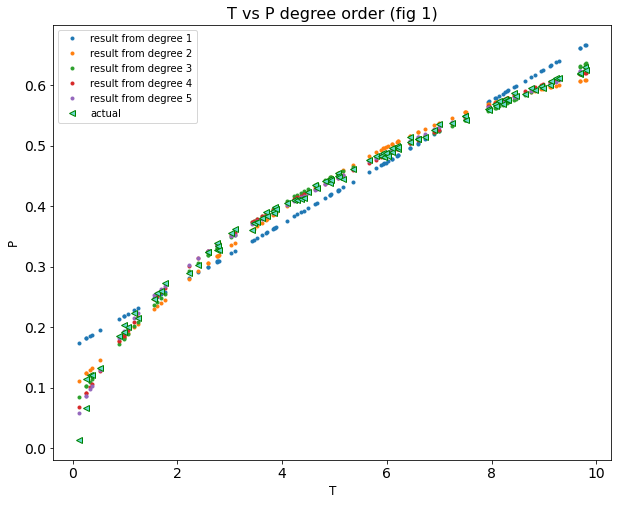

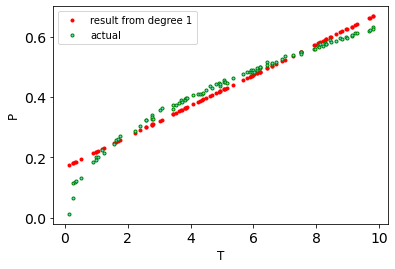

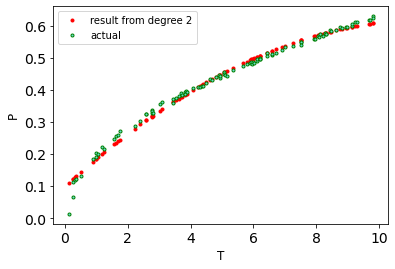

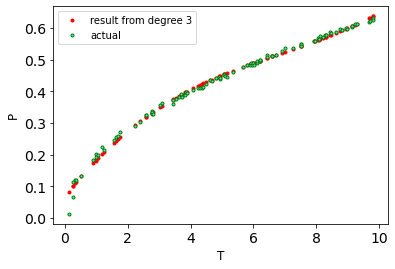

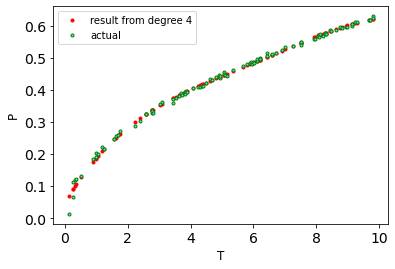

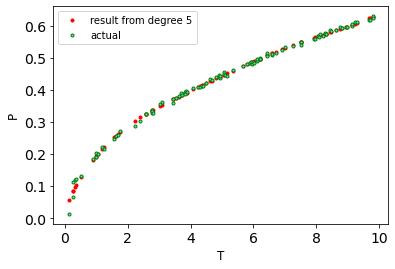

error for degree 1 0.10153212182166331
error for degree 2 0.024119904191435032
error for degree 3 0.011501997234266599
error for degree 4 0.007514266180164218
error for degree 5 0.006090691069178552


In [155]:
#code for 2a
def qr(A):
    m      = len(A)
    n      = len(A[0])
    Q      = np.eye(m)
    R      = A
    length = 0
    if n == m:   
        length = n-1
    else:
        length = n
    for i in range(length):
        H         = np.eye(m)
        H[i:, i:] = householder(R[i:, i])
        Q         = np.dot(Q, H)
        R         = np.dot(H, R)
        
    return Q, R

def householder(r):
    v     = r.copy()
    v[0]  = r[0] + np.sign(r[0]) * np.linalg.norm(r)
    H     = np.eye(len(r))
    H     = H - (2./np.dot(v, v))* (v[:,None].dot(v[None,:]))
    return H

def find(T,P,n):
    A = np.ones((len(T), n+1))
    for i in range(1, n+1):
        A[:, i] = T**i
    Q, R = qr(A)
    b    = P
    Q_tp = np.transpose(Q)
    C    = Q_tp.dot(b)
    
    r = R[:n+1,:n+1].copy()
    c = C[:n+1].copy()
    x = np.zeros(n+1)
    x[n] = c[n]/r[n,n]
    for i in np.arange(n-1,-1,-1):
        x[i] =  c[i]
        for j in np.arange(i+1,n+1,1):
            x[i] = x[i] - r[i,j]*x[j]
        x[i] = x[i]/r[i,i]
    data = x
    return data, A

sol_lst   = []
error_lst = []

for k in range (1, 6):
    x_solve, A  = find(T,P,k)
    sol         = A.dot(x_solve)
    err         = np.sum((sol-P)**2)
    sol_lst.append(sol)
    error_lst.append(err)

index = T.argsort()
plt.figure(figsize=(10,8))

for i in range(5):
    plt.plot(T[index],sol_lst[i][index], '.', label='result from degree {:d}'.format(i+1))
plt.plot(T[Ind],P[Ind], color='green',linestyle='none', marker = '<', markerfacecolor='#67dbd0',label='actual')
plt.xlabel('T',fontsize=12)
plt.ylabel('P',fontsize=12)
plt.title('T vs P degree order (fig 1)',fontsize=16)
plt.legend()
plt.show()

for i in range(5):
    plt.plot(T[index],sol_lst[i][index], color = 'red', linestyle = 'none', marker ='.', label='result from degree {:d}'.format(i+1))
    plt.plot(T[Ind],P[Ind], color='green', linestyle = 'none', marker = '.', markerfacecolor='#67dbd0',label='actual')
    plt.xlabel('T', fontsize=12)
    plt.ylabel('P', fontsize=12)
    plt.legend()
    plt.show()



for i in range(len(error_lst)):
    print("error for degree {:d}".format(i+1), error_lst[i])
    


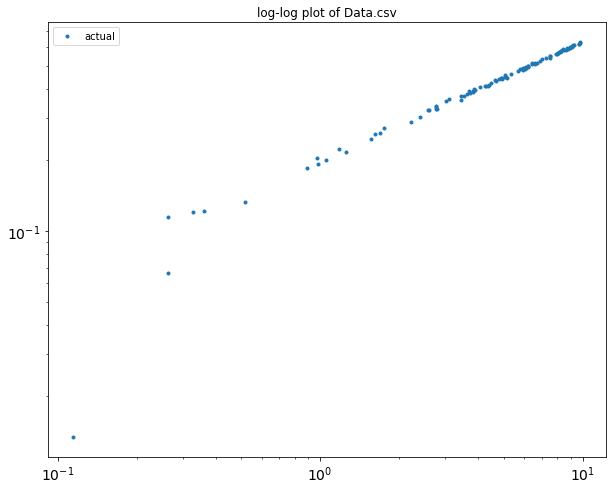

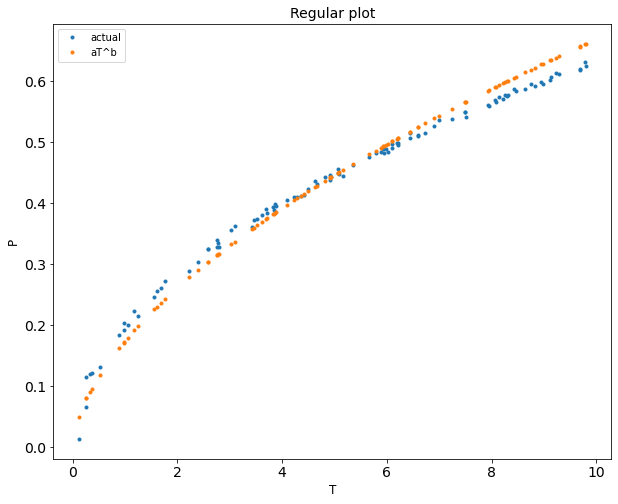

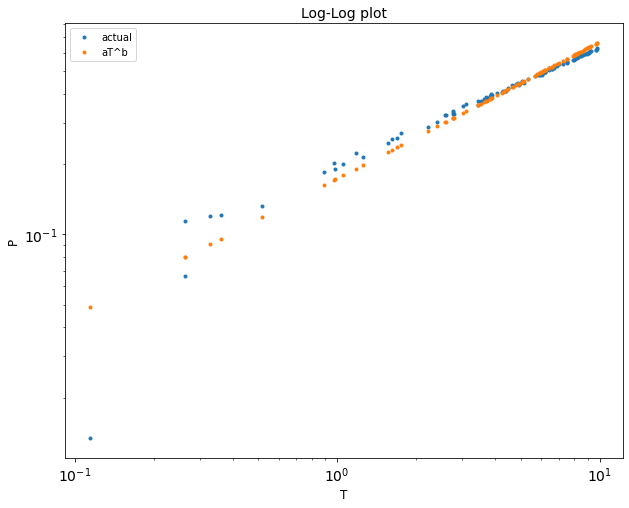

a:  0.17423094977408768
b:  0.5841553750686934
The modeling error is  0.19239802810216866


In [177]:
#code for 2b
plt.figure(figsize=(10,8))
plt.loglog(T,P, linestyle = 'none', marker ='.', label="actual")
plt.title("log-log plot of Data.csv")
plt.legend()
plt.show()

x_sol, junk  = find(np.log(T), np.log(P), 1)
a = np.exp(x_sol[0])
b = x_sol[1]

aTb = a*T**b

#plot regularly with values (T_i, P_i)
plt.figure(figsize=(10,8))
plt.plot(T,P,'.',label='actual')
plt.plot(T,aTb,'.',label='aT^b')
plt.legend()
plt.xlabel('T',fontsize=12)
plt.ylabel('P',fontsize=12)
plt.title('Regular plot',fontsize=14)
plt.show()

#now plot log log with values (T_i, P_i)
plt.figure(figsize=(10,8))
plt.loglog(T,P,'.',label='actual')
plt.loglog(T,aTb,'.',label='aT^b')
plt.legend()
plt.xlabel('T',fontsize=12)
plt.ylabel('P',fontsize=12)
plt.title('Log-Log plot',fontsize=14)
plt.show()

print("a: ", a)
print("b: ", b)

print("The modeling error is ", np.linalg.norm(aTb - P))